In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Step 1: imports and path setup

import pandas as pd
import json
import ast
import re
from pathlib import Path
import matplotlib.pyplot as plt

base_dir = Path("/content/drive/MyDrive/LLM-Flame_War-Samples")

# Key subfolders
human_dir = base_dir / "human_mediation"
llm_step1_dir = base_dir / "llm_mediation" / "step1_output"
comp_dir = base_dir / "comparative_analysis"
comp_dir.mkdir(exist_ok=True, parents=True)

print("Base dir:", base_dir.resolve())
print("Human mediation CSVs:", list(human_dir.glob("*.csv")))
print("LLM step1_output topic folders:",
      [p.name for p in llm_step1_dir.iterdir() if p.is_dir()])

Base dir: /content/drive/MyDrive/LLM-Flame_War-Samples
Human mediation CSVs: [PosixPath('/content/drive/MyDrive/LLM-Flame_War-Samples/human_mediation/gab.csv'), PosixPath('/content/drive/MyDrive/LLM-Flame_War-Samples/human_mediation/reddit.csv')]
LLM step1_output topic folders: ['Sport-158', 'Game-47', 'Technology-40', 'Lifestyle-71', 'Religion-121', 'Social Justice-84']


In [4]:
# Step 2 (Reddit-only): Load & clean human mediation data

import pandas as pd
import ast

# Path to reddit.csv
reddit_path = human_dir / "reddit.csv"

# Load the CSV
reddit_df = pd.read_csv(reddit_path)
print("Raw reddit rows:", len(reddit_df))

def parse_response(x):
    """
    reddit 'response' column = stringified Python list:
    Example: "['sentence1', 'sentence2']"
    Convert to Python list, then join into one mediation message.
    """
    if pd.isna(x) or x == "n/a":
        return ""
    try:
        lst = ast.literal_eval(x)
        if isinstance(lst, list):
            return " ".join(str(item).strip() for item in lst)
        return str(lst)
    except:
        return ""

# Create mediation_text column
reddit_df["mediation_text"] = reddit_df["response"].apply(parse_response)

# Drop rows with missing / empty mediation text
reddit_df = reddit_df[reddit_df["mediation_text"].str.strip() != ""]

# Add source column for completeness
reddit_df["source"] = "reddit"

# Final human_df for Part 5
human_df = reddit_df[["source", "text", "mediation_text"]].reset_index(drop=True)

print("Clean reddit mediation rows:", len(human_df))
human_df.head()

Raw reddit rows: 5020
Clean reddit mediation rows: 3847


,source,text,mediation_text
0,reddit,1. A subsection of retarded Hungarians? Ohh bo...,I don't see a reason why it's okay to insult o...
1,reddit,"1. > ""y'all hear sumn?"" by all means I live i...",Persons with disabilities is the accepted term...
2,reddit,1. Because the Japanese aren't retarded and kn...,It's not right for anyone of any gender to be ...
3,reddit,1. That might be true if we didn't have an exa...,You shouldn't be bringing up sensitive topics....
4,reddit,"1. Why, what is the point of making all of tha...","The term you have used is unnecessary, and mak..."


In [7]:
# Step 3: Load & clean LLM mediation from step1_output

import json
from pathlib import Path
import pandas as pd

# HARD-SET PATH (avoids accidental Google Drive recursion)
llm_step1_dir = Path("/content/drive/MyDrive/LLM-Flame_War-Samples/llm_mediation/step1_output")

print("Using directory:", llm_step1_dir)

llm_rows = []

# SAFETY CHECK: ensure this is the correct folder
topic_folders = [p for p in llm_step1_dir.iterdir() if p.is_dir()]
print("Topic folders found:", [p.name for p in topic_folders])

for topic_folder in topic_folders:
    topic_name = topic_folder.name

    # Only process JSON files (safety filter)
    json_files = list(topic_folder.glob("*.json"))
    print(f"Loading {len(json_files)} files from topic:", topic_name)

    for json_file in json_files:
        try:
            with open(json_file, "r") as f:
                data = json.load(f)

            judgement = data.get("judgement", "").strip()
            steering = data.get("steering", "").strip()

            if judgement:
                llm_rows.append({
                    "topic": topic_name,
                    "post_id": json_file.stem,
                    "mode": "judgement",
                    "mediation_text": judgement
                })

            if steering:
                llm_rows.append({
                    "topic": topic_name,
                    "post_id": json_file.stem,
                    "mode": "steering",
                    "mediation_text": steering
                })

        except Exception as e:
            print("Error in file:", json_file, "->", e)

llm_df = pd.DataFrame(llm_rows)

print("\nTotal LLM mediation rows:", len(llm_df))
llm_df.head()

Using directory: /content/drive/MyDrive/LLM-Flame_War-Samples/llm_mediation/step1_output
Topic folders found: ['Sport-158', 'Game-47', 'Technology-40', 'Lifestyle-71', 'Religion-121', 'Social Justice-84']
Loading 158 files from topic: Sport-158
Loading 47 files from topic: Game-47
Loading 40 files from topic: Technology-40
Loading 71 files from topic: Lifestyle-71
Loading 120 files from topic: Religion-121
Loading 84 files from topic: Social Justice-84

Total LLM mediation rows: 1040


,topic,post_id,mode,mediation_text
0,Sport-158,zamm0a,judgement,The argument that watching football is a legit...
1,Sport-158,zamm0a,steering,Let’s focus on the fact that we all enjoy watc...
2,Sport-158,zh6vtz,judgement,The person defending Messi's 'no look' assist ...
3,Sport-158,zh6vtz,steering,It seems like we're all just having a fun deba...
4,Sport-158,zprbop,judgement,The argument that soccer is a financially viab...


In [15]:
comp_dir.mkdir(exist_ok=True, parents=True)

human_out_path = comp_dir / "human_mediation_reddit_clean.csv"
llm_out_path   = comp_dir / "llm_mediation_step1_clean.csv"

human_df.to_csv(human_out_path, index=False)
llm_df.to_csv(llm_out_path, index=False)

print("Saved human mediation to:", human_out_path)
print("Saved LLM mediation to:", llm_out_path)

# Quick sanity check: reload once (optional)
human_check = pd.read_csv(human_out_path)
llm_check = pd.read_csv(llm_out_path)

print("Reloaded shapes -> human:", human_check.shape, " llm:", llm_check.shape)

Saved human mediation to: /content/drive/MyDrive/LLM-Flame_War-Samples/comparative_analysis/human_mediation_reddit_clean.csv
Saved LLM mediation to: /content/drive/MyDrive/LLM-Flame_War-Samples/comparative_analysis/llm_mediation_step1_clean.csv
Reloaded shapes -> human: (3847, 8)  llm: (1040, 9)


In [16]:
# Step 4: Aggression Metric Functions

import re

# --- 1. Tokenizer ---
def tokenize(text):
    """Split text into simple lowercase tokens."""
    return [w.lower() for w in re.findall(r"[A-Za-z']+", text)]


# --- 2. Toxicity Lexicon ---
TOXIC_TERMS = {
    # set1
    "idiot", "stupid", "moron", "dumb", "trash", "loser",
    "retard", "retarded", "fool", "nonsense", "hate", "kill",

    # set2
    "idiotic", "dumbass", "shit", "shitty", "garbage", "pathetic",
    "worthless", "useless", "delusional", "ignorant", "clown",

    # profanity / slurs (appearing in your reddit dataset)
    "fuck", "fucking", "bitch", "cunt", "whore", "faggot"
}

def toxicity_count(text):
    """Counts toxic lexicon items (simple approach)."""
    tokens = tokenize(text)
    count = 0
    for i, t in enumerate(tokens):
        if t in TOXIC_TERMS:
            count += 1
        # Detect phrase "shut up"
        if t == "shut" and i + 1 < len(tokens) and tokens[i+1] == "up":
            count += 1
    return count


# --- 3. Exclamation emphasis ---
def exclamation_count(text):
    return text.count("!")


# --- 4. CAPS Ratio ---
def caps_ratio(text):
    words = re.findall(r"\b\w+\b", text)
    if not words:
        return 0.0
    caps_words = [w for w in words if len(w) > 1 and w.isupper()]
    return len(caps_words) / len(words)


# --- 5. Argumentativeness Proxy ---
ARG_PATTERNS = [
    # original
    "you are", "you're", "youre", "your fault", "you clearly",
    "you obviously", "you do not", "you don't", "you people",
    "you should", "you need to", "you must",
    "are you serious", "do you even", "why don't you",
    "let me tell you", "listen", "this is why people like you",
    "what kind of person"
]

def argumentativeness_score(text):
    """
    Detect ONLY genuinely confrontational/aggressive second-person patterns.
    Does NOT count neutral "you" usage.

    Returns:
        int: Binary 0 or 1 (0 = no attacks, 1 = attacks detected)
    """
    lower = text.lower()

    # Only patterns that indicate ATTACKS/CONFRONTATION
    ATTACK_PATTERNS = [
        # Direct insults
        r"you are\s+(wrong|stupid|idiot|moron|dumb|pathetic|ignorant)",
        r"you're\s+(wrong|stupid|idiot|moron|dumb|pathetic|ignorant)",

        # Dismissive
        r"you\s+don't\s+(understand|know|get it)",
        r"you\s+can't\s+even",
        r"you\s+clearly\s+don't",
        r"you\s+obviously\s+don't",

        # Accusatory
        r"you\s+always",
        r"you\s+never",
        r"your\s+fault",
        r"you\s+people",

        # Hostile imperatives
        r"shut\s+up",
        r"get\s+lost",

        # Confrontational questions
        r"are\s+you\s+serious",
        r"are\s+you\s+kidding",
        r"what\s+is\s+wrong\s+with\s+you",
    ]

    # Check if ANY attack pattern exists
    for pattern in ATTACK_PATTERNS:
        if re.search(pattern, lower):
            return 1  # Binary: attack detected

    return 0  # No attacks


def composite_aggression(text):
    """
    Weighted combination with BINARY argumentativeness.
    """
    tox = toxicity_count(text)
    exc = exclamation_count(text)
    caps = caps_ratio(text)
    arg = argumentativeness_score(text)  # Now 0 or 1

    # Direct weighting (no normalization needed for binary arg)
    return (
        (tox * 2.0) +        # Toxic words
        (arg * 5.0) +        # Personal attacks (binary, so higher weight)
        (caps * 1.0) +       # CAPS
        (exc * 0.5)          # Exclamations
    )

print("Metric functions ready.")


Metric functions ready.


In [17]:
# Step 5: Apply aggression metrics to human_df and llm_df

# If you restarted the notebook, uncomment these two lines to reload:
# human_df = pd.read_csv(comp_dir / "human_mediation_reddit_clean.csv")
# llm_df   = pd.read_csv(comp_dir / "llm_mediation_step1_clean.csv")

metric_cols = ["toxicity", "exclamations", "caps_ratio", "argumentativeness", "composite"]

# --- Apply to HUMAN mediation (reddit) ---
human_df["toxicity"]          = human_df["mediation_text"].apply(toxicity_count)
human_df["exclamations"]      = human_df["mediation_text"].apply(exclamation_count)
human_df["caps_ratio"]        = human_df["mediation_text"].apply(caps_ratio)
human_df["argumentativeness"] = human_df["mediation_text"].apply(argumentativeness_score)
human_df["composite"]         = human_df["mediation_text"].apply(composite_aggression)

print("Human mediation metrics (head):")
display(human_df[["mediation_text"] + metric_cols].head())


# --- Apply to LLM mediation (judgement + steering) ---
llm_df["toxicity"]          = llm_df["mediation_text"].apply(toxicity_count)
llm_df["exclamations"]      = llm_df["mediation_text"].apply(exclamation_count)
llm_df["caps_ratio"]        = llm_df["mediation_text"].apply(caps_ratio)
llm_df["argumentativeness"] = llm_df["mediation_text"].apply(argumentativeness_score)
llm_df["composite"]         = llm_df["mediation_text"].apply(composite_aggression)

print("\nLLM mediation metrics (head):")
display(llm_df[["topic", "mode", "mediation_text"] + metric_cols].head())

# --- Save scored versions to comparative_analysis ---
human_scored_path = comp_dir / "human_mediation_reddit_scored.csv"
llm_scored_path   = comp_dir / "llm_mediation_step1_scored.csv"

human_df.to_csv(human_scored_path, index=False)
llm_df.to_csv(llm_scored_path, index=False)

print("\nSaved scored human mediation to:", human_scored_path)
print("Saved scored LLM mediation to:", llm_scored_path)

# --- Quick summary stats you'll use in the report ---

print("\n=== Mean metrics: HUMAN (reddit) ===")
print(human_df[metric_cols].mean())

print("\n=== Mean metrics: LLM overall ===")
print(llm_df[metric_cols].mean())

print("\n=== Mean metrics: LLM by mode (judgement vs steering) ===")
print(llm_df.groupby("mode")[metric_cols].mean())


Human mediation metrics (head):


,mediation_text,toxicity,exclamations,caps_ratio,argumentativeness,composite
0,I don't see a reason why it's okay to insult o...,0,0,0.0,0,0.0
1,Persons with disabilities is the accepted term...,0,0,0.0,0,0.0
2,It's not right for anyone of any gender to be ...,0,0,0.0,0,0.0
3,You shouldn't be bringing up sensitive topics....,0,0,0.0,0,0.0
4,"The term you have used is unnecessary, and mak...",0,0,0.0,0,0.0



LLM mediation metrics (head):


,topic,mode,mediation_text,toxicity,exclamations,caps_ratio,argumentativeness,composite
0,Sport-158,judgement,The argument that watching football is a legit...,0,0,0.000000,0,0.000000
1,Sport-158,steering,Let’s focus on the fact that we all enjoy watc...,0,0,0.000000,0,0.000000
2,Sport-158,judgement,The person defending Messi's 'no look' assist ...,0,0,0.000000,0,0.000000
3,Sport-158,steering,It seems like we're all just having a fun deba...,0,0,0.000000,0,0.000000
4,Sport-158,judgement,The argument that soccer is a financially viab...,0,0,0.033333,0,0.033333



Saved scored human mediation to: /content/drive/MyDrive/LLM-Flame_War-Samples/comparative_analysis/human_mediation_reddit_scored.csv
Saved scored LLM mediation to: /content/drive/MyDrive/LLM-Flame_War-Samples/comparative_analysis/llm_mediation_step1_scored.csv

=== Mean metrics: HUMAN (reddit) ===
toxicity             0.345984
exclamations         0.071224
caps_ratio           0.000924
argumentativeness    0.003899
composite            0.748000
dtype: float64

=== Mean metrics: LLM overall ===
toxicity             0.074038
exclamations         0.000962
caps_ratio           0.003952
argumentativeness    0.000000
composite            0.152510
dtype: float64

=== Mean metrics: LLM by mode (judgement vs steering) ===
           toxicity  exclamations  caps_ratio  argumentativeness  composite
mode                                                                       
judgement  0.086538      0.000000    0.005298                0.0   0.178375
steering   0.061538      0.001923    0.002606   

✅ Saved: llm_vs_human_comparison.png


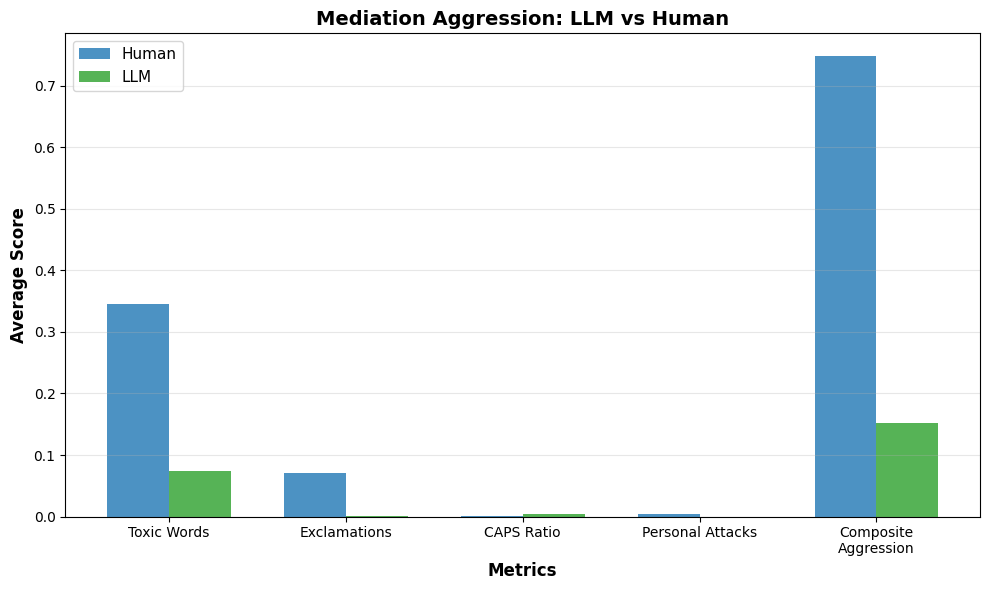

✅ Saved: judgment_vs_steering.png


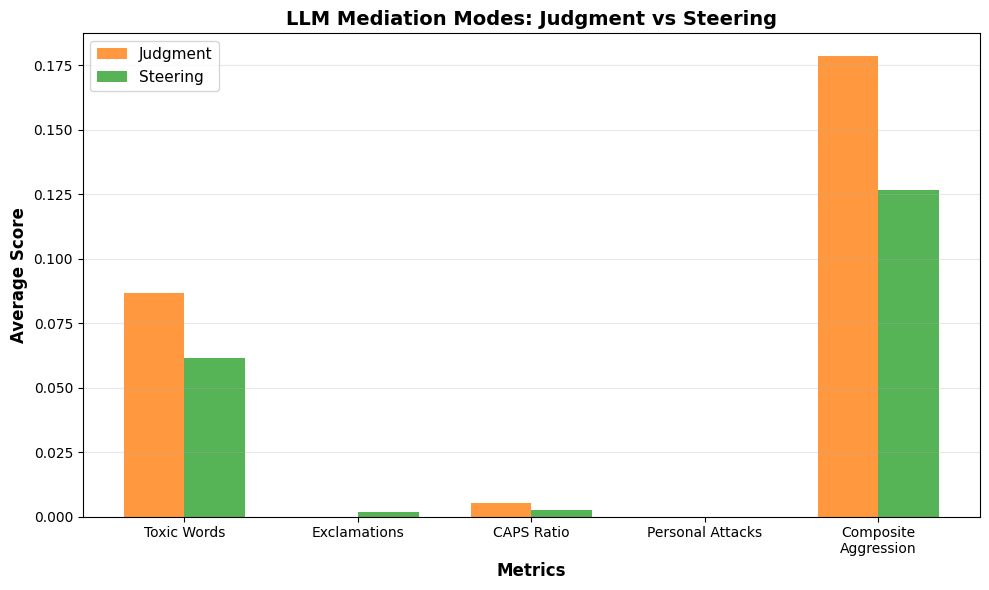


=== STATISTICAL TESTS ===

1. LLM vs Human (composite aggression):
   t = -13.478, p = 0.0000
   *** Highly significant (p < 0.001)

2. Judgment vs Steering (composite aggression):
   t = 1.457, p = 0.1453


In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Visualization 1: LLM vs Human Comparison
fig, ax = plt.subplots(figsize=(10, 6))

metrics = ['toxicity', 'exclamations', 'caps_ratio', 'argumentativeness', 'composite']
labels = ['Toxic Words', 'Exclamations', 'CAPS Ratio', 'Personal Attacks', 'Composite\nAggression']

human_means = [human_df[m].mean() for m in metrics]
llm_means = [llm_df[m].mean() for m in metrics]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax.bar(x - width/2, human_means, width, label='Human', color='#1f77b4', alpha=0.8)
bars2 = ax.bar(x + width/2, llm_means, width, label='LLM', color='#2ca02c', alpha=0.8)

ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Score', fontsize=12, fontweight='bold')
ax.set_title('Mediation Aggression: LLM vs Human', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=10)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(comp_dir / 'llm_vs_human_comparison.png', dpi=300, bbox_inches='tight')
print("✅ Saved: llm_vs_human_comparison.png")
plt.show()


# Visualization 2: Judgment vs Steering
fig, ax = plt.subplots(figsize=(10, 6))

judgment_means = [llm_df[llm_df['mode']=='judgement'][m].mean() for m in metrics]
steering_means = [llm_df[llm_df['mode']=='steering'][m].mean() for m in metrics]

bars1 = ax.bar(x - width/2, judgment_means, width, label='Judgment', color='#ff7f0e', alpha=0.8)
bars2 = ax.bar(x + width/2, steering_means, width, label='Steering', color='#2ca02c', alpha=0.8)

ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Score', fontsize=12, fontweight='bold')
ax.set_title('LLM Mediation Modes: Judgment vs Steering', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=10)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(comp_dir / 'judgment_vs_steering.png', dpi=300, bbox_inches='tight')
print("✅ Saved: judgment_vs_steering.png")
plt.show()


# Visualization 3: Statistical Significance
from scipy import stats

print("\n=== STATISTICAL TESTS ===")
print("\n1. LLM vs Human (composite aggression):")
t_stat, p_val = stats.ttest_ind(llm_df['composite'], human_df['composite'])
print(f"   t = {t_stat:.3f}, p = {p_val:.4f}")
if p_val < 0.001:
    print("   *** Highly significant (p < 0.001)")

print("\n2. Judgment vs Steering (composite aggression):")
judgment_data = llm_df[llm_df['mode']=='judgement']['composite']
steering_data = llm_df[llm_df['mode']=='steering']['composite']
t_stat, p_val = stats.ttest_ind(judgment_data, steering_data)
print(f"   t = {t_stat:.3f}, p = {p_val:.4f}")
if p_val < 0.001:
    print("   *** Highly significant (p < 0.001)")
elif p_val < 0.05:
    print("   * Significant (p < 0.05)")

In [18]:
# Find human mediations with highest toxicity
high_tox_human = human_df.nlargest(5, 'composite')[['mediation_text', 'composite']]
print(high_tox_human)

                                         mediation_text  composite
3294  Hey, I wish you wouldn't mock people with ment...       12.0
573   >Uses hate speech to prove hate speech doesn't...       10.0
1496  This thread is closed. We ask that you all rev...       10.0
1800  Mentally challenged individuals tend to be hig...       10.0
3092  Mentally challenged individuals tend to be hig...       10.0


In [19]:
# Show some judgment mediations
print(llm_df[llm_df['mode']=='judgement'].sample(3)[['mediation_text', 'composite']])

                                        mediation_text  composite
672  The people distinguishing between faith as tru...        2.0
242  The argument that Mbappe's nationality and eth...        0.0
844  The argument that popularity of a religion is ...        0.0


In [20]:
# Show some steering mediations
print(llm_df[llm_df['mode']=='steering'].sample(3)[['mediation_text', 'composite']])

                                        mediation_text  composite
775  It's clear we're all passionate about this top...    0.00000
673  It's interesting to see how faith can be a dou...    0.00000
295  Let’s keep the discussion civil. We can disagr...    0.03125
